In [1]:
#Import Required Libraries
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.models import Sequential
import torchvision
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report
from keras.layers import Dense
from tensorflow.keras import layers

In [2]:
#Mount google drive(Ignore this step if not using google colab for training)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# check whether gpu available for training (Always train deep learning models on GPU which has faster processing)
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


Checking How many images for each Label

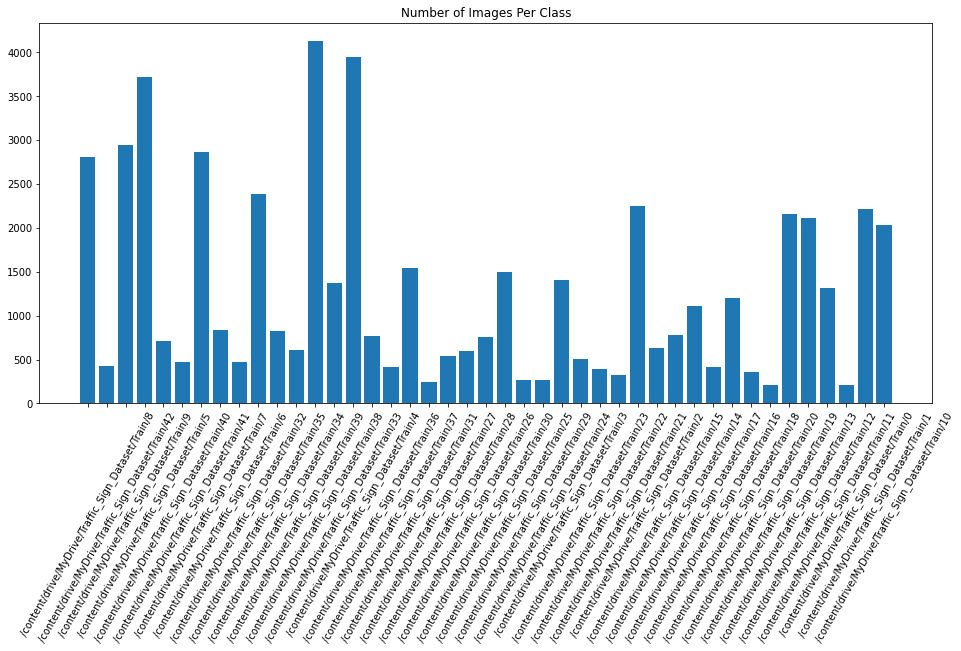

In [4]:
#check no of images per label
train_path = '/content/drive/MyDrive/Traffic_Sign_Dataset/Train'
class_names = os.listdir(train_path)

list_path = []
list_image_count = []

for name in class_names:
    img_folder_path = train_path + '/' + name
    dirListing = len(os.listdir(img_folder_path))
    list_path.append(img_folder_path)
    list_image_count.append(dirListing)
fig = plt.figure(figsize =(16, 7))

plt.bar(list_path, list_image_count)
plt.xticks(rotation=60)
plt.title('Number of Images Per Class')
plt.show()

# Preprocessing

In [5]:
#Setting Conditions
img_size = (224,224) #set image size (width, height) VGG16 has input image size as (224,224)
batch_size = 32 #set batch size in powers of two. Batch size defines how many images are taken together to calcualte gradient
num_classes = len(class_names) #total number of classes for training

In [6]:
#Using Keras built in preprocessing method which facilitates the preprocessing instead of having to do it manually.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode = 'categorical', #it is used for multiclass classification. It is one hot encoded labels for each class
    validation_split = 0.2,     #percentage of dataset to be considered for validation
    subset = "training",        #this subset is used for training
    seed = 1337,                # seed is set so that same results are reproduced
    image_size = img_size,      # shape of input images
    batch_size = batch_size,    # This should match with model batch size
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode ='categorical',
    validation_split = 0.2,
    subset = "validation",      #this subset is used for validation
    seed = 1337,
    image_size = img_size,
    batch_size = batch_size,
)


Found 55101 files belonging to 43 classes.
Using 44081 files for training.
Found 55101 files belonging to 43 classes.
Using 11020 files for validation.


# BUILDING MODEL

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16  #import VGG16 model

In [8]:
## Loading VGG16 model
#Transfer learning using VGG16 model
#Imagenet dataset trained weights are used for transfer learning
# include_top = False implies that only bottleneck(bottom layers) part is used for transfer learning which has better feature representation of images.
# We add some layers to top layers and fine tune it
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3)) 
base_model.trainable = False ## Not trainable weights. Imagenet weights are used directly. only forward propogation happens through base model and weights are not learnt.
model = Sequential([
    base_model,
    layers.Flatten(), # Flatten the output from VGG16 to individual neurons
    layers.Dense(64, activation='relu'), # add dense layer of 64 neurons and activation as relu. It learns random relationship between pixels in  an image.
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # It is prediction layer
    #It has no. of neurons = number of classes and sum of the output from this layer is 1 due to softmax activation
])
model.summary() #check the model structure

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 43)                1419      
                                                                 
Total params: 16,323,883
Trainable params: 1,609,195
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Traffic_Sign_Dataset'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, #save model path
    monitor='val_accuracy',       # save model if it has maximum val accuracy among trained epochs
    mode='max',
    save_best_only=True) 
# Model weights are saved at the end of every epoch, if it's the best seen
# so far

In [10]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics =['accuracy'])
epochs = 2 #number of times complete data is seen by model

In [11]:
fit_model = model.fit(train_ds, epochs = epochs, verbose = 1, validation_data = valid_ds, callbacks=[model_checkpoint])

Epoch 1/2
1378/1378 [==============================] - 6997s 5s/step - loss: 0.9019 - accuracy: 0.7802 - val_loss: 0.3797 - val_accuracy: 0.9030
Epoch 2/2
1378/1378 [==============================] - 410s 297ms/step - loss: 0.2563 - accuracy: 0.9290 - val_loss: 0.2132 - val_accuracy: 0.9460


In [12]:
model.save('/content/drive/MyDrive/Traffic_Sign_Dataset/model.h5')

In [17]:
class_names = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24',
               '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40',
               '41', '42', '5', '6', '7', '8', '9']
test_folder_path = '/content/drive/MyDrive/Traffic_Sign_Dataset/Test'
for filename in os.listdir(test_folder_path):
  img = tf.keras.utils.load_img(
      os.path.join(test_folder_path, filename), target_size=img_size)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = predictions[0]
  predicted_class = class_names[np.argmax(score)]
  accuracy = np.max(score) * 100
  print('predicted class is:', predicted_class)
  print('accuracy:', round(accuracy, 2))

Streaming output truncated to the last 5000 lines.
predicted class is: 5
accuracy: 56.32
predicted class is: 8
accuracy: 99.57
predicted class is: 40
accuracy: 75.19
predicted class is: 34
accuracy: 56.26
predicted class is: 20
accuracy: 99.7
predicted class is: 5
accuracy: 100.0
predicted class is: 6
accuracy: 98.17
predicted class is: 27
accuracy: 98.17
predicted class is: 5
accuracy: 6.67
predicted class is: 36
accuracy: 50.5
predicted class is: 39
accuracy: 15.98
predicted class is: 22
accuracy: 78.85
predicted class is: 6
accuracy: 95.61
predicted class is: 20
accuracy: 60.32
predicted class is: 27
accuracy: 99.79
predicted class is: 2
accuracy: 100.0
predicted class is: 5
accuracy: 85.63
predicted class is: 40
accuracy: 99.86
predicted class is: 38
accuracy: 93.05
predicted class is: 28
accuracy: 7.59
predicted class is: 34
accuracy: 38.95
predicted class is: 27
accuracy: 75.41
predicted class is: 28
accuracy: 55.83
predicted class is: 14
accuracy: 70.3
predicted class is: 9
accu

UnidentifiedImageError: ignored

In [18]:
print(class_names)

['8', '42', '9', '5', '40', '41', '7', '6', '32', '35', '34', '39', '38', '33', '4', '36', '37', '31', '27', '28', '26', '30', '25', '29', '24', '3', '23', '22', '21', '2', '15', '14', '17', '16', '18', '20', '19', '13', '12', '11', '0', '1', '10']
